In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures 

# 1. Getting The Data

Getting the data is in a seperate notebook, so we'll just read it in I guess.

In [2]:
# read the data
mv = pd.read_csv('data/pl_mv.csv')
standings = pd.read_csv('data/pl_standings.csv')

# 2. Cleaning and Preparing the Data (Some EDA As Well)

In [3]:
mv.head()

,team,squad,age,foreigners,total_market_value,season
0,Chelsea,27,24.5,19,£316.96m,2005
1,Man Utd,29,24.9,20,£257.78m,2005
2,Arsenal,33,23.3,28,£196.16m,2005
3,Liverpool,32,23.9,23,£168.66m,2005
4,Spurs,30,24.5,15,£130.95m,2005


The total Market value is a string, to do analysis on it we need it to be of type float. So we'll create a new column "total_cleaned" with the number value.

### Note
Man city's squad value last season was over a BILLION pounds. So we have to convert it to millions like all other rows.

In [4]:
# possible solution with regex
# Man City broke it for having a squad value for over a billion, thanks a lot Man City
"""
temp_list = []
for i in mv['total_market_value']:
    temp = re.findall("\d+\.\d+", i)
    temp_list.append(float(temp[0]))
"""

'\ntemp_list = []\nfor i in mv[\'total_market_value\']:\n    temp = re.findall("\\d+\\.\\d+", i)\n    temp_list.append(float(temp[0]))\n'

In [5]:
# clean total_market_value (account for Man City's billion pounds squad)
mv['total_cleaned'] = None
for i, v in mv.iterrows():
    if v['total_market_value'][-1] == 'm':
        mv.at[i, 'total_cleaned'] = float(v['total_market_value'][1:-1])
    else:
        mv.at[i, 'total_cleaned'] = float(v['total_market_value'][1:-2]) * 1000

In [6]:
mv.head(3)

,team,squad,age,foreigners,total_market_value,season,total_cleaned
0,Chelsea,27,24.5,19,£316.96m,2005,316.96
1,Man Utd,29,24.9,20,£257.78m,2005,257.78
2,Arsenal,33,23.3,28,£196.16m,2005,196.16


Now let's look at the team with the highest market value for each season.

In [7]:
# max total for each season
max_ssn = mv.groupby('season').agg({'team': 'first', 'total_cleaned': 'max'}).reset_index()

In [8]:
max_ssn.head()

,season,team,total_cleaned
0,2005,Chelsea,316.96
1,2006,Chelsea,363.49
2,2007,Chelsea,381.83
3,2008,Chelsea,363.78
4,2009,Chelsea,399.51


In [9]:
max_ssn[max_ssn['season'] == 2005]['total_cleaned'][0]

316.96

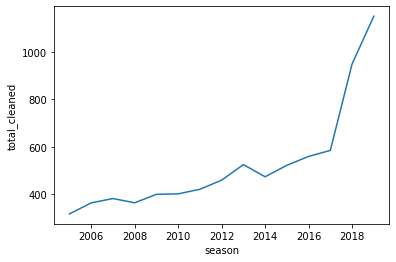

In [10]:
# quickly visualise it
sns.lineplot(data=max_ssn, x="season", y="total_cleaned")

Squad values increase with time. We already knew that, but it's an important detail to consider when doing this analysis. Because a team with a certain squad value in 2005 shouldn't be treated equally as a team with the same squad value in 2019.

To deal with this we will add a new column: **relative_value**. For each season, we will divide the squad value by the max squad value for that season. 

In [11]:
# let's add a relative value column
mv['relative_value'] = None
for i, v in mv.iterrows():
    mv.at[i, 'relative_value'] = v['total_cleaned'] /\
    max_ssn[max_ssn['season'] == v['season']]['total_cleaned'].values[0]

In [12]:
mv['total_cleaned'] = mv['total_cleaned'].astype('float64')
mv['relative_value'] = mv['relative_value'].astype('float64')

In [13]:
mv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   team                300 non-null    object 
 1   squad               300 non-null    int64  
 2   age                 300 non-null    float64
 3   foreigners          300 non-null    int64  
 4   total_market_value  300 non-null    object 
 5   season              300 non-null    int64  
 6   total_cleaned       300 non-null    float64
 7   relative_value      300 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 18.9+ KB


### Merging time!!
Now that we've got the relative values, it's time to merge the standings df with our market values df to see how many points did every team get in each season and their positions.

In [14]:
pts_mv = pd.merge(mv, standings, on=['team', 'season'])

In [15]:
pts_mv.head(3)

,team,squad,age,foreigners,total_market_value,season,total_cleaned,relative_value,position,matches,gd,pts
0,Chelsea,27,24.5,19,£316.96m,2005,316.96,1.000000,1,38,50,91
1,Man Utd,29,24.9,20,£257.78m,2005,257.78,0.813289,2,38,38,83
2,Arsenal,33,23.3,28,£196.16m,2005,196.16,0.618879,4,38,37,67


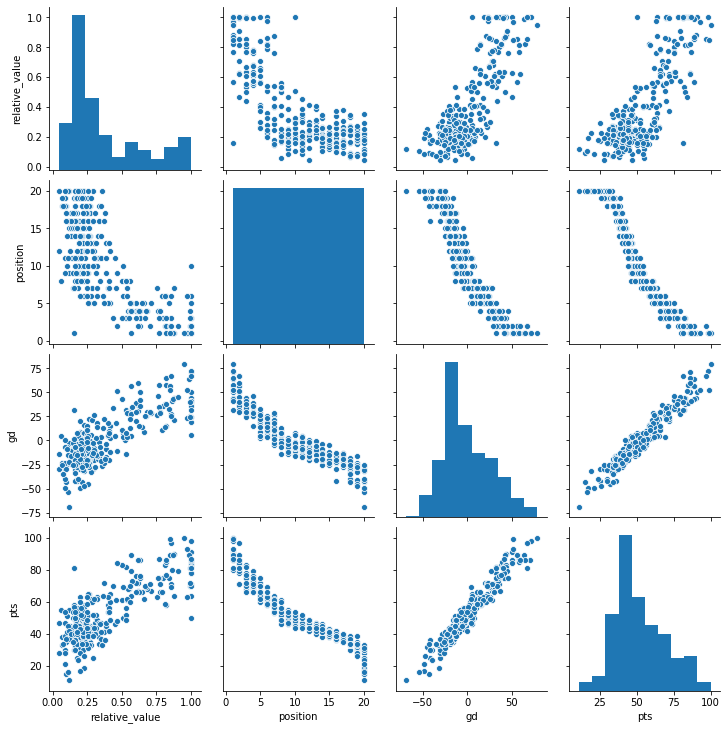

In [16]:
# let's quickly visualise some relationships
sns.pairplot(pts_mv[['relative_value', 'position', 'gd', 'pts']])

## Observations
- Let's start with the obvious one, goal difference is highly correlated to points, who would've thought!
- The relative value is correlated to the number of points, but it's looking more like a curve than a line (looks kinda cubic to me). 
- The relative value is also correlated to the position. 

So we need to figure out how we're gonna measure the performance of a team, the choice is between points and position. Let's see who's more highly correlated with the relative value. 

I'm coming from the future to tell you that it's gonna be \*drum roll* 
**number of points!!**

In [17]:
print(abs(pts_mv['relative_value'].corr(pts_mv['position'])))
print(abs(pts_mv['relative_value'].corr(pts_mv['pts'])))

0.7443711255483554
0.8013556352948995


It's modelling time!!

# 3. Building The Model

In [18]:
# get the features and the labels
X = pts_mv['relative_value']
y = pts_mv['pts']

print(X.shape)
print(y.shape)

(300,)
(300,)


In [19]:
# now let's reshape 
X = X.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

print(X.shape)
print(y.shape)

(300, 1)
(300, 1)


In [20]:
# split into train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
# instantiate the model and fit to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0.5, 1.0, 'EPL Squad relative value vs actual points')

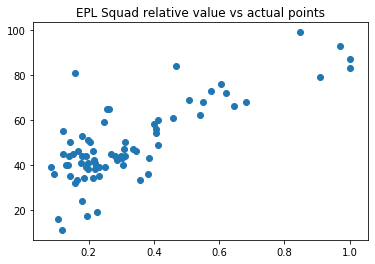

In [22]:
predictions = lm.predict(X_test)

plt.scatter(X_test, y_test)
plt.title("EPL Squad relative value vs actual points")

Text(0.5, 1.0, 'EPL Squad relative value vs predicted points')

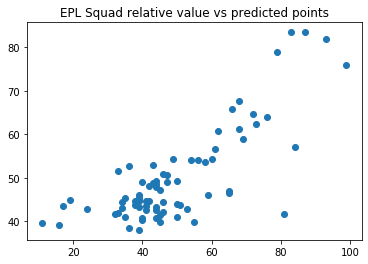

In [23]:
plt.scatter(y_test, predictions)
plt.title("EPL Squad relative value vs predicted points")

In [28]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))

MAE: 8.173494724411372


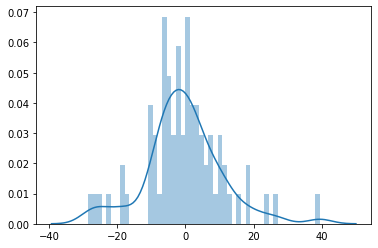

In [25]:
sns.distplot((y_test-predictions),bins=50)

In [26]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
df.head(5)

,Actual,Predicted
0,66,65.818281
1,54,54.009464
2,41,43.617562
3,45,47.124397
4,41,44.739691


In [27]:
df['Actual'].corr(df['Predicted'])

0.7818626078446193